# Direct imaging of exoplanets

Simple example of direct exoplanet imaging.


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

import pickle
import pylops

In [2]:
with open('../data/bpic_all.p', 'rb') as f:
    data = pickle.load(f)
    psf = pickle.load(f)
    fwhm = pickle.load(f)
    location = pickle.load(f)

In [3]:
data[:,44:57,44:57] = 0
data_mat = data.reshape(-1,np.prod(data.shape[-2:]))
location

(61, 61)

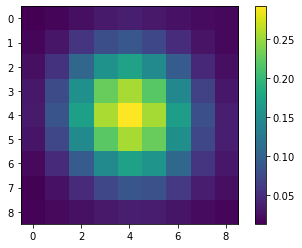

In [4]:
#from skimage.transform import resize
#psf_resized = resize(psf, (140, 54))
cx = 20
cy = 20
rx = 5
ry = 5
kernel = psf[cy-ry:cy+ry-1,cx-rx:cx+rx-1]
kernel = kernel / np.linalg.norm(kernel,ord = 'fro')
plt.imshow(kernel)
plt.colorbar()

In [5]:
class Trajectorlet(object):
    def __init__(self, shape, kernel):
        self._kernel = kernel
        self._shape = shape
        self._conv2d = pylops.signalprocessing.Convolve2D(
            N = np.prod(self._shape[-2:]),
            dims=self._shape[-2:],
            h=self._kernel,
            offset = (self._kernel.shape[0]//2+1, self._kernel.shape[1]//2+1)
        )

    def matvec(self, x):
       y = self._conv2d.matvec(x)
       return np.tile(y, (self._shape[0], 1)).flatten() # possibly just repmat here

    def rmatvec(self, y):
        x = self._conv2d.rmatvec(y.reshape(self._shape[0],-1).sum(axis=0))
        return x #np.tile(x, (self._shape[0], 1))
trajectorlet = Trajectorlet(data.shape, kernel)

In [6]:
rho_r = 0.01
rho_s = 0.1
delta = 0.5

m = data.shape[0]
n = np.prod(data.shape[-2:])

r = 20
s = 10

HTr = FixedRank(r)
HTs = Sparsity(s)


class Ai(object):
    def __init__(self):
        pass

    def matvec(self, x):
        return x

    def rmatvec(self, y):
        return y

# Prepare transform
As = (TensorLinearOperator((m,n)), trajectorlet)
b = data_mat.flatten()

In [18]:
solver = NAHT(logverbosity = 2, maxiter = 50)
problem = LinearProblemSum(As, b, (HTr, HTs))

In [19]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm
    1	+4.4046518162872314e+09	5.63615674e+03
    2	+4.3697664337036133e+09	5.63609863e+03
    3	+4.3942785680854797e+09	5.63412402e+03
    4	+4.3633124783325195e+09	5.63524609e+03
    5	+4.3837492972686768e+09	5.63299365e+03
    6	+4.3505901312568665e+09	5.63145361e+03
    7	+4.3915742280714111e+09	5.63516357e+03
    8	+4.3461284051623840e+09	5.63299463e+03
    9	+4.3635912723731689e+09	5.62920215e+03
   10	+4.3332435088129883e+09	5.63049121e+03
   11	+4.3522547575476379e+09	5.62813965e+03
   12	+4.3253108817583008e+09	5.62760156e+03
   13	+4.3476683308113098e+09	5.62761426e+03
   14	+4.3114876235940247e+09	5.62435791e+03
   15	+4.3360462357837219e+09	5.62517676e+03
   16	+4.3055727320019836e+09	5.62563867e+03
   17	+4.3291963212110596e+09	5.62370605e+03
   18	+4.2998509900108643e+09	5.62076514e+03
   19	+4.3157399173574524e+09	5.62137598e+03
   20	+4.2841996353274231e+09	5.62143750e+03
   21	+4.2984072048672180e+09	5.61881250e+03
   22	+4.2752984357

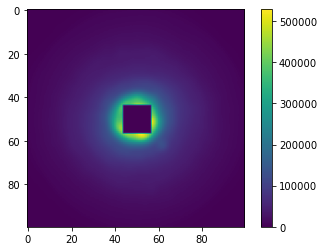

In [20]:
plt.imshow(data.sum(axis=0))
plt.colorbar()

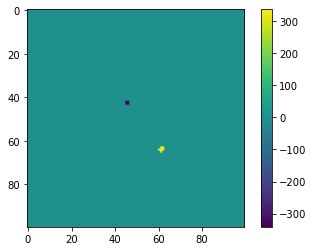

In [34]:
plt.imshow(x[1].reshape(data.shape[-2:]))
plt.colorbar()

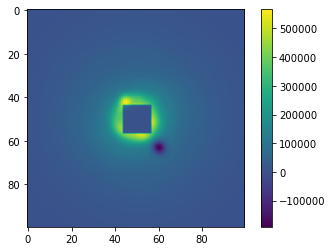

In [28]:
plt.imshow(x[0].reshape(data.shape).sum(axis=0))
plt.colorbar()

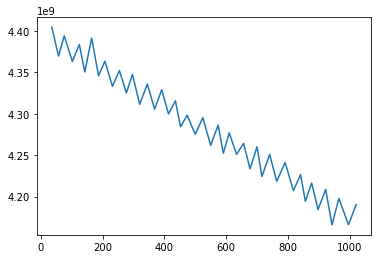

In [32]:
plt.plot(opt_log['iterations']['time'], opt_log['iterations']['fx'])